## Setup

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import torch
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, multilabel_confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Hubungkan ke Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definisikan path utama proyek
PROJECT_PATH = "/content/drive/MyDrive/CODE SKRIPSI"

print("Setup Selesai.")

Setup Selesai.


## Fungsi

In [ ]:
def load_slang_dict(filepath):
    """Memuat kamus slang dari file CSV."""
    df_slang = pd.read_csv(filepath, header=None, names=['slang', 'formal'], encoding='latin-1')
    return pd.Series(df_slang.formal.values, index=df_slang.slang).to_dict()

def preprocess_text(text, slang_dictionary):
    """Membersihkan dan menormalisasi teks."""
    text = str(text).lower()
    words = text.split()
    normalized_words = [slang_dictionary.get(word, word) for word in words]
    text = " ".join(normalized_words)
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_function(examples, tokenizer):
    """Menokenisasi teks."""
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

def find_per_label_thresholds(trainer, val_dataset, label_columns):
    """
    Mencari threshold klasifikasi optimal untuk SETIAP LABEL secara individual
    berdasarkan F1-score di validation set.
    """
    print("\n" + "="*50)
    print("Mencari Threshold Optimal Per Label...")
    print("="*50)

    print("Mendapatkan prediksi probabilitas pada validation set...")
    predictions_output = trainer.predict(val_dataset)
    y_probas = 1 / (1 + np.exp(-predictions_output.predictions)) # Sigmoid
    y_true = predictions_output.label_ids

    optimal_thresholds = {}

    # Loop untuk setiap label
    for i, label in enumerate(label_columns):
        best_threshold_for_label = 0.5
        best_f1_for_label = 0

        probas_for_label = y_probas[:, i]
        true_for_label = y_true[:, i]

        for threshold in np.arange(0.1, 0.9, 0.01):
            pred_for_label = (probas_for_label > threshold).astype(int)
            f1 = f1_score(true_for_label, pred_for_label, pos_label=1, zero_division=0)

            if f1 > best_f1_for_label:
                best_f1_for_label = f1
                best_threshold_for_label = threshold

        optimal_thresholds[label] = round(best_threshold_for_label, 2)
        print(f"  - Label '{label}': Threshold Optimal = {optimal_thresholds[label]} (F1: {best_f1_for_label:.4f})")

    print("\n Pencarian threshold per label selesai.")
    return optimal_thresholds

def display_final_evaluation_visuals(y_true, y_pred, label_columns):
    """
    Menampilkan visualisasi Classification Report dan Confusion Matrix.
    """
    # Visualisasi Metrik Per Label (Classification Report)
    print("\n" + "="*50)
    print("Visualisasi Metrik Per Label (dari Test Set)")
    print("="*50)

    report_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=label_columns, zero_division=0, output_dict=True)).transpose()
    report_df_labels = report_df.drop(['micro avg', 'macro avg', 'weighted avg', 'samples avg'])

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))
    report_df_labels[['precision', 'recall', 'f1-score']].plot(kind='bar', ax=ax, rot=45, width=0.8)
    ax.set_title('Perbandingan Precision, Recall, dan F1-Score per Label', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Visualisasi Confusion Matrix
    print("\n" + "="*50)
    print("Visualisasi Confusion Matrix Per Label (dari Test Set)")
    print("="*50)

    mcm = multilabel_confusion_matrix(y_true, y_pred)
    fig, axes = plt.subplots(4, 3, figsize=(15, 18))
    axes = axes.flatten()
    for i, (matrix, label) in enumerate(zip(mcm, label_columns)):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i], xticklabels=['Not', 'Is'], yticklabels=['Not', 'Is'])
        axes[i].set_title(f'CM untuk: {label}', fontsize=12)
    if len(label_columns) < len(axes):
        for j in range(len(label_columns), len(axes)): fig.delaxes(axes[j])
    plt.tight_layout(pad=3.0)
    plt.show()

print(" Kumpulan Fungsi Evaluasi Siap.")

 Kumpulan Fungsi Evaluasi Siap.


In [ ]:
print("Mempersiapkan dataset...")

DATA_PATH = os.path.join(PROJECT_PATH, 'data/data.csv')
SLANG_DICT_PATH = os.path.join(PROJECT_PATH, 'data/new_kamusalay.csv')
df = pd.read_csv(DATA_PATH, encoding='latin-1')
slang_dict = load_slang_dict(SLANG_DICT_PATH)

df['text'] = df['Tweet' if 'Tweet' in df.columns else 'tweet'].apply(lambda x: preprocess_text(x, slang_dict))
label_columns = ["HS", "HS_Individual", "HS_Group", "HS_Religion", "HS_Race", "HS_Physical", "HS_Gender", "HS_Other", "HS_Weak", "HS_Moderate", "HS_Strong"]

df['labels'] = df[label_columns].astype(np.float32).values.tolist()

# Lakukan split untuk mendapatkan val_df dan test_df yang KONSISTEN
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.111, random_state=42)

# Buat dan tokenisasi dataset
tokenizer_for_eval = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)
val_dataset = val_dataset.map(lambda x: tokenize_function(x, tokenizer_for_eval), batched=True)
test_dataset = test_dataset.map(lambda x: tokenize_function(x, tokenizer_for_eval), batched=True)

print(f" Validation Set ({len(val_df)} sampel) dan Test Set ({len(test_df)} sampel) siap.")

Mempersiapkan dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/1316 [00:00<?, ? examples/s]

Map:   0%|          | 0/1317 [00:00<?, ? examples/s]

 Validation Set (1316 sampel) dan Test Set (1317 sampel) siap.


Memuat model dari: /content/drive/MyDrive/CODE SKRIPSI/revisi/MODEL_FINAL_SIDANG_REVISI

Mencari Threshold Optimal Per Label...
Mendapatkan prediksi probabilitas pada validation set...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  - Label 'HS': Threshold Optimal = 0.8 (F1: 0.9813)
  - Label 'HS_Individual': Threshold Optimal = 0.85 (F1: 0.9767)
  - Label 'HS_Group': Threshold Optimal = 0.77 (F1: 0.9819)
  - Label 'HS_Religion': Threshold Optimal = 0.72 (F1: 0.9686)
  - Label 'HS_Race': Threshold Optimal = 0.36 (F1: 0.9833)
  - Label 'HS_Physical': Threshold Optimal = 0.39 (F1: 0.9565)
  - Label 'HS_Gender': Threshold Optimal = 0.6 (F1: 0.9836)
  - Label 'HS_Other': Threshold Optimal = 0.84 (F1: 0.9758)
  - Label 'HS_Weak': Threshold Optimal = 0.88 (F1: 0.9769)
  - Label 'HS_Moderate': Threshold Optimal = 0.71 (F1: 0.9723)
  - Label 'HS_Strong': Threshold Optimal = 0.82 (F1: 1.0000)

 Pencarian threshold per label selesai.

Evaluasi Final pada Test Set dengan Threshold Per-Label


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Menerapkan threshold optimal per label...
--- Laporan Klasifikasi Final dengan Threshold Optimal Per-Label ---
               precision    recall  f1-score   support

           HS       0.94      0.99      0.96       558
HS_Individual       0.96      0.98      0.97       356
     HS_Group       0.93      0.98      0.95       202
  HS_Religion       0.94      0.95      0.94        78
      HS_Race       0.86      0.98      0.92        55
  HS_Physical       0.93      0.96      0.95        27
    HS_Gender       0.90      0.90      0.90        29
     HS_Other       0.95      0.98      0.97       387
      HS_Weak       0.96      0.97      0.96       343
  HS_Moderate       0.91      0.98      0.94       180
    HS_Strong       0.95      1.00      0.97        35

    micro avg       0.94      0.98      0.96      2250
    macro avg       0.93      0.97      0.95      2250
 weighted avg       0.94      0.98      0.96      2250
  samples avg       0.42      0.41      0.42      2250


Visu

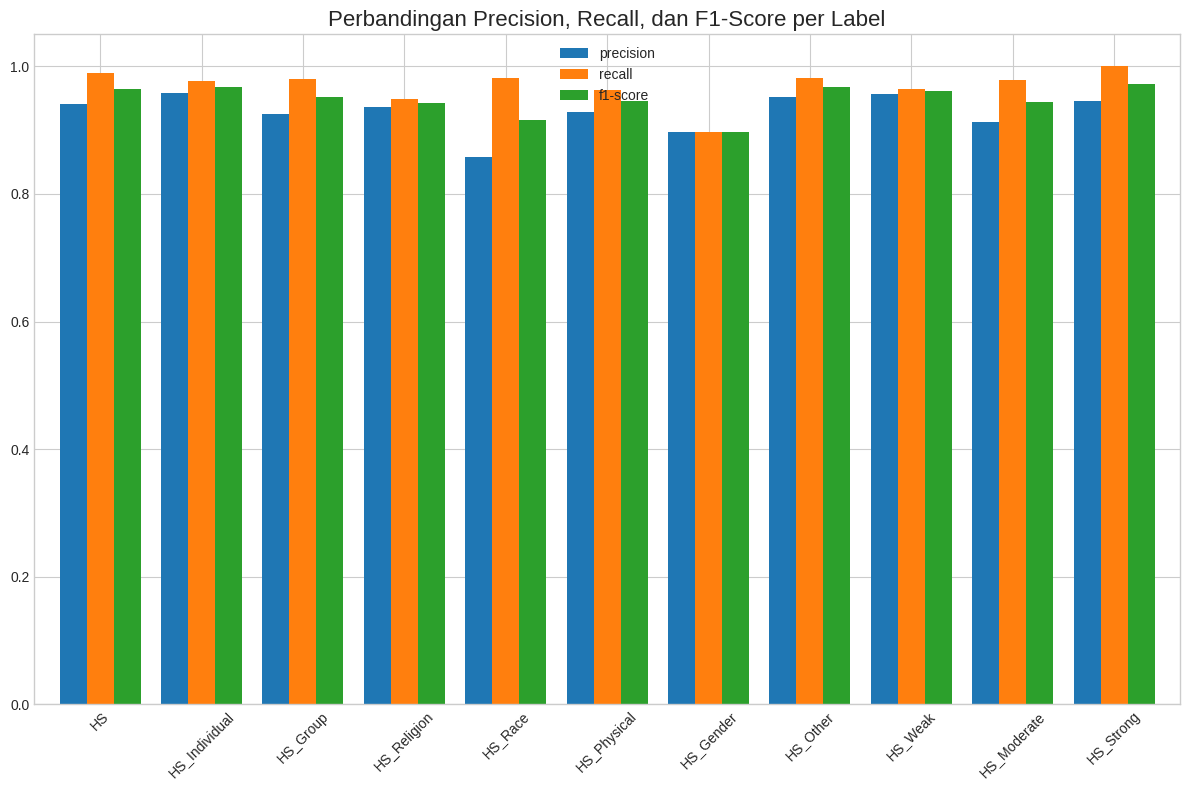


Visualisasi Confusion Matrix Per Label (dari Test Set)


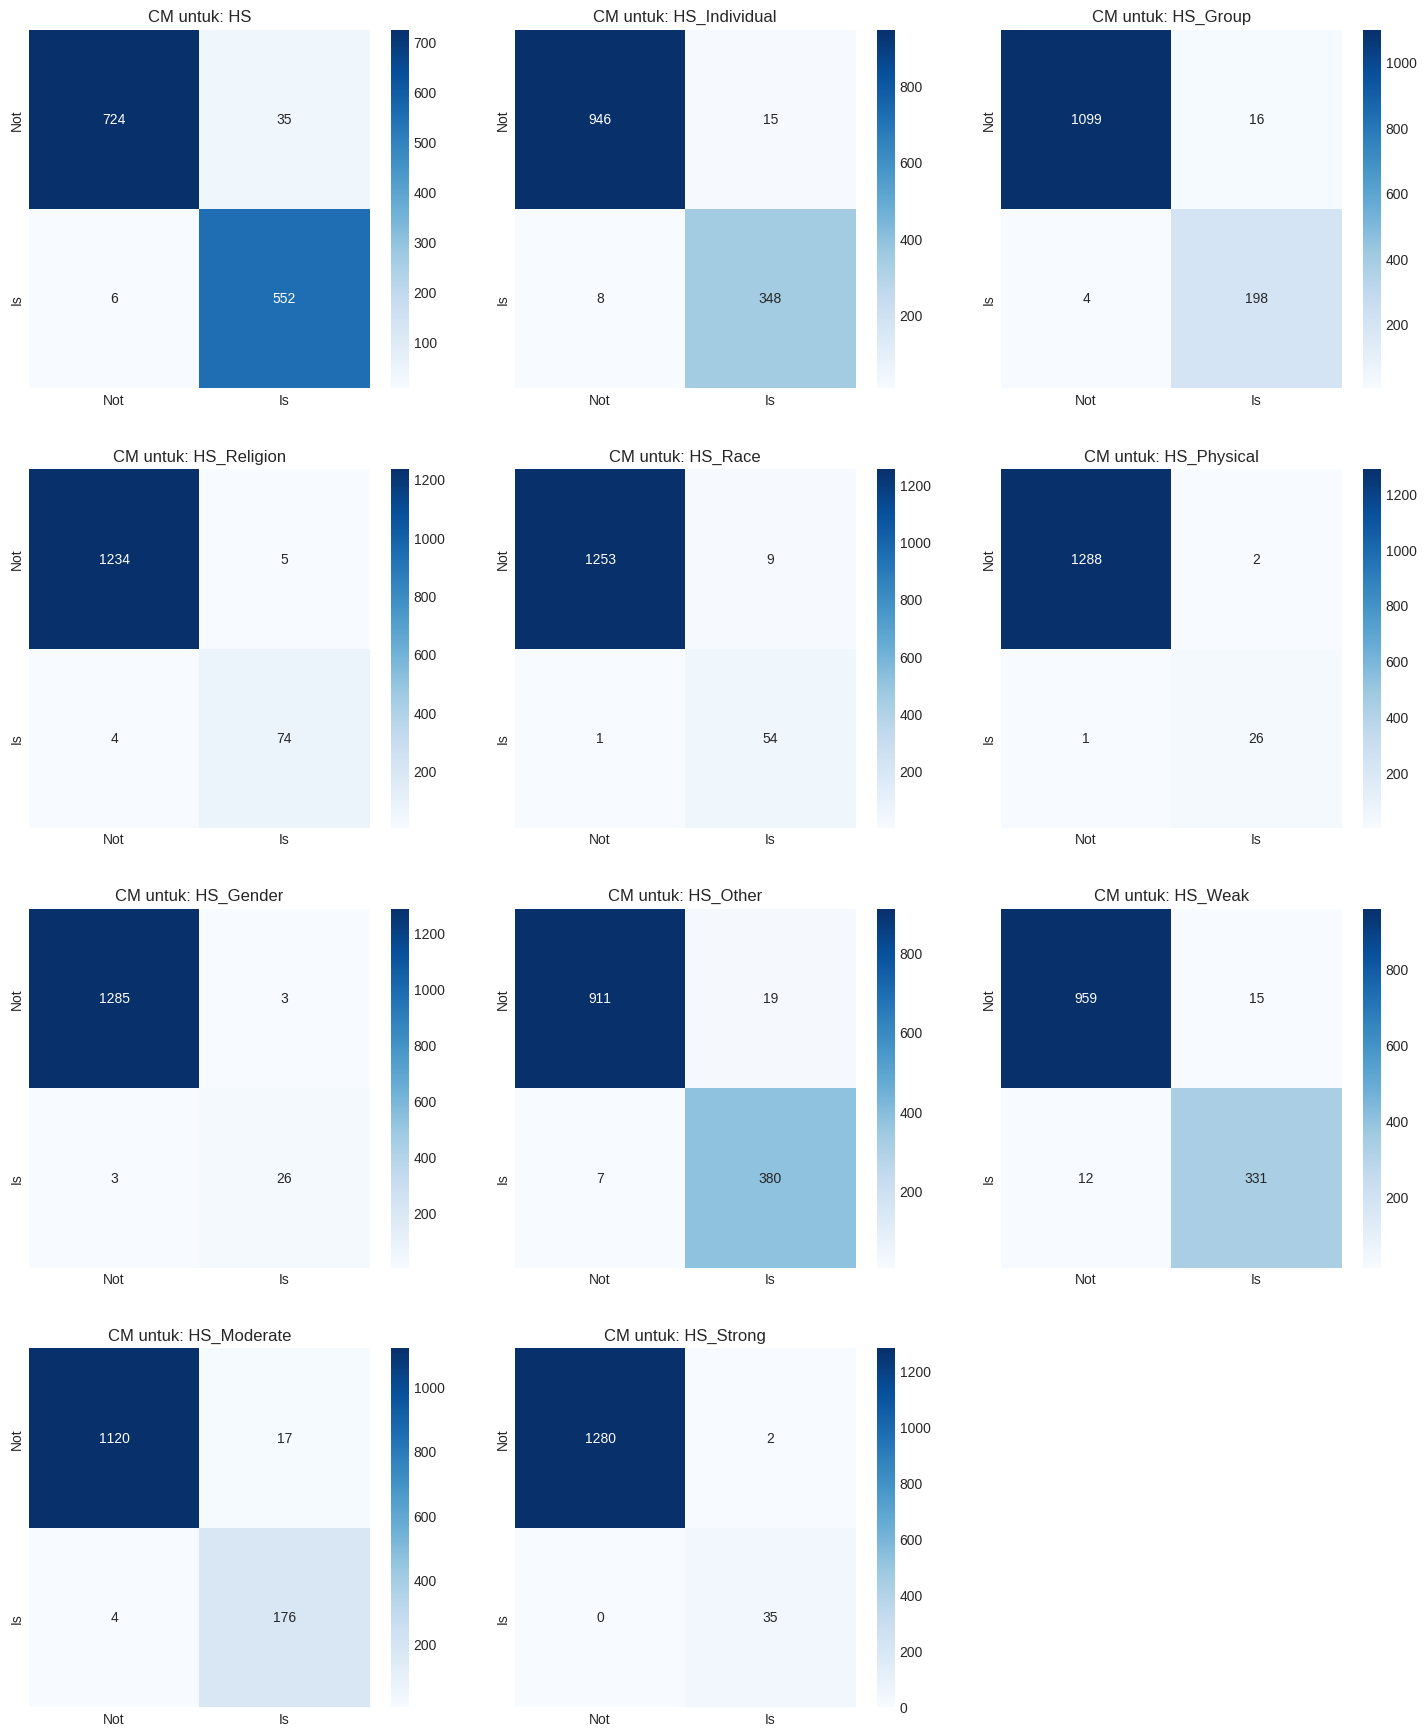

In [ ]:
PATH_MODEL_TERBAIK = "/content/drive/MyDrive/CODE SKRIPSI/revisi/MODEL_FINAL_SIDANG_REVISI"

print(f"Memuat model dari: {PATH_MODEL_TERBAIK}")

# Load model
model_final = AutoModelForSequenceClassification.from_pretrained(PATH_MODEL_TERBAIK)

# Buat Trainer sementara untuk prediksi
args_eval = TrainingArguments(output_dir="./temp_eval", report_to="none")
trainer_final = Trainer(model=model_final, args=args_eval)

# Mencari threshold optimal untuk SETIAP LABEL menggunakan validation set
per_label_thresholds = find_per_label_thresholds(trainer_final, val_dataset, label_columns)

# Melakukan evaluasi akhir pada TEST SET menggunakan threshold per-label
print("\n" + "="*50)
print(f"Evaluasi Final pada Test Set dengan Threshold Per-Label")
print("="*50)

# Dapatkan prediksi (probabilitas) dari test set
predictions_output_test = trainer_final.predict(test_dataset)
y_probas_test = 1 / (1 + np.exp(-predictions_output_test.predictions))
y_true_test = predictions_output_test.label_ids

# Buat array kosong untuk prediksi akhir
y_pred_optimal = np.zeros_like(y_probas_test)

# Terapkan threshold yang berbeda untuk setiap kolom label
print("\nMenerapkan threshold optimal per label...")
for i, label in enumerate(label_columns):
    threshold = per_label_thresholds[label]
    y_pred_optimal[:, i] = (y_probas_test[:, i] > threshold).astype(int)

# Tampilkan laporan klasifikasi final
report_final = classification_report(y_true_test, y_pred_optimal, target_names=label_columns, zero_division=0)
print("--- Laporan Klasifikasi Final dengan Threshold Optimal Per-Label ---")
print(report_final)

# Panggil fungsi untuk menampilkan semua visualisasi
display_final_evaluation_visuals(y_true_test, y_pred_optimal, label_columns)